# Data Wrangling WeRateDogs Project

## Introduction

The purpose of this project is to use all the steps in the data wrangling process, namely data gathering, data assessing and data cleaning, and then analyze and visualize this wrangled data.

The data used for this project is real live Twitter data from the Twitter account 'WeRateDogs'. This Twitter account is according to the account itself the only source for professional dog ratings.

## Gathering Data 

In this Gathering Data section of the project we will use the following three steps to collect all the data necessary for the following steps in this project:

1. WeRateDogs Twitter archive: This CSV file holds data on tweets from the WeRateDogs Twitter account. The CSV file was already prepared by Udacity.
2. Tweet image predictions: This TSV file holds data on what type of breeds are present in each tweet. The TSV file was already prepared by Udacity.
3. Twitter web scraping with an API: with the API we can creeate a tweet_json.txt file and based on that create a pandas DataFrame including at least tweet ID, retweet count, and favorite count. 

In [1]:
# import all necessary packages

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import os
import requests
import tweepy
from tweepy import OAuthHandler
import json
from timeit import default_timer as timer
import re

#### 1. WeRateDogs Twitter archive

In [2]:
# read csv file

df_twitter_archive = pd.read_csv('twitter-archive-enhanced.csv')

In [3]:
# check first lines of csv file

df_twitter_archive.head()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,None,None,None,None
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,None,None,None,None
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,None,None,None,None


In [4]:
df_twitter_archive.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
tweet_id                      2356 non-null int64
in_reply_to_status_id         78 non-null float64
in_reply_to_user_id           78 non-null float64
timestamp                     2356 non-null object
source                        2356 non-null object
text                          2356 non-null object
retweeted_status_id           181 non-null float64
retweeted_status_user_id      181 non-null float64
retweeted_status_timestamp    181 non-null object
expanded_urls                 2297 non-null object
rating_numerator              2356 non-null int64
rating_denominator            2356 non-null int64
name                          2356 non-null object
doggo                         2356 non-null object
floofer                       2356 non-null object
pupper                        2356 non-null object
puppo                         2356 non-null object
dtypes: float64(4), int64(3), ob

#### 2. Tweet image predictions

In [5]:
# read tsv file

df_image_predictions = pd.read_csv('image-predictions.tsv', '\t')

In [6]:
# check first lines of tsv file

df_image_predictions.head()

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True


#### 3. Twitter web scraping with an API

In [7]:
# keys and passwords for twitter API (keys and passwords are HIDDEN here for security reasons)

consumer_key = 'HIDDEN'
consumer_secret = 'HIDDEN'
access_token = 'HIDDEN'
access_secret = 'HIDDEN'

In [8]:
# get data from Twitter API 

auth = OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_secret)

api = tweepy.API(auth, wait_on_rate_limit=True)

tweet_ids = df_twitter_archive.tweet_id.values
len(tweet_ids)

2356

In [9]:
# Query Twitter's API for JSON data for each tweet ID in the Twitter archive

count = 0
fails_dict = {}
start = timer()
 Save each tweet's returned JSON as a new line in a .txt file
with open('tweet_json.txt', 'w') as outfile:
    This loop will likely take 20-30 minutes to run because of Twitter's rate limit
    for tweet_id in tweet_ids:
        count += 1
        print(str(count) + ": " + str(tweet_id))
        try:
            tweet = api.get_status(tweet_id, tweet_mode='extended')
            print("Success")
            json.dump(tweet._json, outfile)
            outfile.write('\n')
        except tweepy.TweepError as e:
            print("Fail")
            fails_dict[tweet_id] = e
            pass
end = timer()
print(end - start)
print(fails_dict)


IndentationError: unexpected indent (<ipython-input-9-6f61fb0cfc21>, line 6)

In [78]:
# create a Pandas DataFrame of the tweet_json.txt file

df_list = []
with open('tweet_json.txt') as file:
    for row in file:
        data = json.loads(row)
        keys = data.keys()
        user = data.get('user')
        id_str = data.get('id_str')
        retweet_count = data.get('retweet_count')
        favorite_count = data.get('favorite_count')
        df_list.append({'tweet_id': id_str,
                        'retweet_count': retweet_count,
                        'favorite_count': favorite_count})
        
df_retweet = pd.DataFrame(df_list, columns = ['tweet_id', 'retweet_count', 'favorite_count'])

In [79]:
# check first lines of df_retweet_fav_count

df_retweet.head()

,tweet_id,retweet_count,favorite_count
0,892420643555336193,7371,35060
1,892177421306343426,5493,30358
2,891815181378084864,3631,22818
3,891689557279858688,7549,38335
4,891327558926688256,8137,36610


## Assessing Data 

After gathering each of the above pieces of data, in this section, I will assess them visually and programmatically for quality and tidiness issues for the 3 following datasets:

1. `twitter_archive` table
2. `image_ predictions` table
3. `retweet` table

At the end of this section the quality and tidiness improvements are stated per table.

#### 1. `twitter_archive` table

In [80]:
# check out the data

df_twitter_archive

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,None,None,None,None
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,None,None,None,None
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,None,None,None,None
5,891087950875897856,NaN,NaN,2017-07-29 00:08:17 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here we have a majestic great white breaching ...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891087950...,13,10,None,None,None,None,None
6,890971913173991426,NaN,NaN,2017-07-28 16:27:12 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Meet Jax. He enjoys ice cream so much he gets ...,NaN,NaN,NaN,"https://gofundme.com/ydvmve-surgery-for-jax,ht...",13,10,Jax,None,None,None,None
7,890729181411237888,NaN,NaN,2017-07-28 00:22:40 +0000,"<a href=""http://twitter.com/download/iphone"" r...",When you watch your owner call another dog a g...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/890729181...,13,10,None,None,None,None,None
8,890609185150312448,NaN,NaN,2017-07-27 16:25:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Zoey. She doesn't want to be one of th...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/890609185...,13,10,Zoey,None,None,None,None
9,890240255349198849,NaN,NaN,2017-07-26 15:59:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Cassie. She is a college pup. Studying...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/890240255...,14,10,Cassie,doggo,None,None,None


In [81]:
# check data types

df_twitter_archive.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
tweet_id                      2356 non-null int64
in_reply_to_status_id         78 non-null float64
in_reply_to_user_id           78 non-null float64
timestamp                     2356 non-null object
source                        2356 non-null object
text                          2356 non-null object
retweeted_status_id           181 non-null float64
retweeted_status_user_id      181 non-null float64
retweeted_status_timestamp    181 non-null object
expanded_urls                 2297 non-null object
rating_numerator              2356 non-null int64
rating_denominator            2356 non-null int64
name                          2356 non-null object
doggo                         2356 non-null object
floofer                       2356 non-null object
pupper                        2356 non-null object
puppo                         2356 non-null object
dtypes: float64(4), int64(3), ob

In [82]:
#check in_reply_to_status_id not null rows for data type

df_twitter_archive[df_twitter_archive['in_reply_to_status_id'].notnull()]

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
30,886267009285017600,8.862664e+17,2.281182e+09,2017-07-15 16:51:35 +0000,"<a href=""http://twitter.com/download/iphone"" r...",@NonWhiteHat @MayhewMayhem omg hello tanner yo...,NaN,NaN,NaN,NaN,12,10,None,None,None,None,None
55,881633300179243008,8.816070e+17,4.738443e+07,2017-07-02 21:58:53 +0000,"<a href=""http://twitter.com/download/iphone"" r...",@roushfenway These are good dogs but 17/10 is ...,NaN,NaN,NaN,NaN,17,10,None,None,None,None,None
64,879674319642796034,8.795538e+17,3.105441e+09,2017-06-27 12:14:36 +0000,"<a href=""http://twitter.com/download/iphone"" r...",@RealKentMurphy 14/10 confirmed,NaN,NaN,NaN,NaN,14,10,None,None,None,None,None
113,870726314365509632,8.707262e+17,1.648776e+07,2017-06-02 19:38:25 +0000,"<a href=""http://twitter.com/download/iphone"" r...",@ComplicitOwl @ShopWeRateDogs &gt;10/10 is res...,NaN,NaN,NaN,NaN,10,10,None,None,None,None,None
148,863427515083354112,8.634256e+17,7.759620e+07,2017-05-13 16:15:35 +0000,"<a href=""http://twitter.com/download/iphone"" r...",@Jack_Septic_Eye I'd need a few more pics to p...,NaN,NaN,NaN,NaN,12,10,None,None,None,None,None
149,863079547188785154,6.671522e+17,4.196984e+09,2017-05-12 17:12:53 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Ladies and gentlemen... I found Pipsy. He may ...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/863079547...,14,10,None,None,None,None,None
179,857214891891077121,8.571567e+17,1.806710e+08,2017-04-26 12:48:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",@Marc_IRL pixelated af 12/10,NaN,NaN,NaN,NaN,12,10,None,None,None,None,None
184,856526610513747968,8.558181e+17,4.196984e+09,2017-04-24 15:13:52 +0000,"<a href=""http://twitter.com/download/iphone"" r...","THIS IS CHARLIE, MARK. HE DID JUST WANT TO SAY...",NaN,NaN,NaN,https://twitter.com/dog_rates/status/856526610...,14,10,None,None,None,None,None
186,856288084350160898,8.562860e+17,2.792810e+08,2017-04-23 23:26:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",@xianmcguire @Jenna_Marbles Kardashians wouldn...,NaN,NaN,NaN,NaN,14,10,None,None,None,None,None
188,855862651834028034,8.558616e+17,1.943518e+08,2017-04-22 19:15:32 +0000,"<a href=""http://twitter.com/download/iphone"" r...",@dhmontgomery We also gave snoop dogg a 420/10...,NaN,NaN,NaN,NaN,420,10,None,None,None,None,None


In [83]:
# check descriptive stats for numerical data types

df_twitter_archive.describe()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,retweeted_status_id,retweeted_status_user_id,rating_numerator,rating_denominator
count,2.356000e+03,7.800000e+01,7.800000e+01,1.810000e+02,1.810000e+02,2356.000000,2356.000000
mean,7.427716e+17,7.455079e+17,2.014171e+16,7.720400e+17,1.241698e+16,13.126486,10.455433
std,6.856705e+16,7.582492e+16,1.252797e+17,6.236928e+16,9.599254e+16,45.876648,6.745237
min,6.660209e+17,6.658147e+17,1.185634e+07,6.661041e+17,7.832140e+05,0.000000,0.000000
25%,6.783989e+17,6.757419e+17,3.086374e+08,7.186315e+17,4.196984e+09,10.000000,10.000000
50%,7.196279e+17,7.038708e+17,4.196984e+09,7.804657e+17,4.196984e+09,11.000000,10.000000
75%,7.993373e+17,8.257804e+17,4.196984e+09,8.203146e+17,4.196984e+09,12.000000,10.000000
max,8.924206e+17,8.862664e+17,8.405479e+17,8.874740e+17,7.874618e+17,1776.000000,170.000000


In [84]:
# value count the dog names

df_twitter_archive['name'].value_counts()

None        745
a            55
Charlie      12
Cooper       11
Oliver       11
Lucy         11
Lola         10
Penny        10
Tucker       10
Bo            9
Winston       9
Sadie         8
the           8
Toby          7
Bailey        7
Buddy         7
an            7
Daisy         7
Milo          6
Stanley       6
Koda          6
Bella         6
Scout         6
Jack          6
Leo           6
Jax           6
Oscar         6
Rusty         6
Dave          6
Chester       5
           ... 
Taz           1
Vinscent      1
Edmund        1
Rooney        1
Birf          1
Furzey        1
Jett          1
Huxley        1
Mutt          1
Darby         1
Opie          1
Berb          1
Suki          1
Tango         1
Jomathan      1
Akumi         1
Brudge        1
Pilot         1
Tassy         1
Shadoe        1
Fiji          1
Kara          1
Brat          1
Siba          1
Kingsley      1
Staniel       1
Dietrich      1
Kevon         1
Jessiga       1
Bowie         1
Name: name, Length: 957,

In [85]:
# create a name_list to check if all the values in the name column have a dog name

sorted(df_twitter_archive['name'].unique().tolist())

['Abby',
 'Ace',
 'Acro',
 'Adele',
 'Aiden',
 'Aja',
 'Akumi',
 'Al',
 'Albert',
 'Albus',
 'Aldrick',
 'Alejandro',
 'Alexander',
 'Alexanderson',
 'Alf',
 'Alfie',
 'Alfy',
 'Alice',
 'Amber',
 'Ambrose',
 'Amy',
 'Amélie',
 'Anakin',
 'Andru',
 'Andy',
 'Angel',
 'Anna',
 'Anthony',
 'Antony',
 'Apollo',
 'Aqua',
 'Archie',
 'Arlen',
 'Arlo',
 'Arnie',
 'Arnold',
 'Arya',
 'Ash',
 'Asher',
 'Ashleigh',
 'Aspen',
 'Astrid',
 'Atlas',
 'Atticus',
 'Aubie',
 'Augie',
 'Autumn',
 'Ava',
 'Axel',
 'Bailey',
 'Baloo',
 'Balto',
 'Banditt',
 'Banjo',
 'Barclay',
 'Barney',
 'Baron',
 'Barry',
 'Batdog',
 'Bauer',
 'Baxter',
 'Bayley',
 'BeBe',
 'Bear',
 'Beau',
 'Beckham',
 'Beebop',
 'Beemo',
 'Bell',
 'Bella',
 'Belle',
 'Ben',
 'Benedict',
 'Benji',
 'Benny',
 'Bentley',
 'Berb',
 'Berkeley',
 'Bernie',
 'Bert',
 'Bertson',
 'Betty',
 'Beya',
 'Biden',
 'Bilbo',
 'Billl',
 'Billy',
 'Binky',
 'Birf',
 'Bisquick',
 'Blakely',
 'Blanket',
 'Blipson',
 'Blitz',
 'Bloo',
 'Bloop',
 'Blu',


In [86]:
# check for duplicated expanded urls

sum(df_twitter_archive['expanded_urls'].duplicated())

137

In [87]:
# check for duplicated rows

sum(df_twitter_archive.duplicated())

0

In [88]:
# check for duplicated IDs

sum(df_twitter_archive['tweet_id'].duplicated())

0

#### 2. `image_ predictions` table

In [89]:
# check out the data

df_image_predictions

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True
5,666050758794694657,https://pbs.twimg.com/media/CT5Jof1WUAEuVxN.jpg,1,Bernese_mountain_dog,0.651137,True,English_springer,0.263788,True,Greater_Swiss_Mountain_dog,0.016199,True
6,666051853826850816,https://pbs.twimg.com/media/CT5KoJ1WoAAJash.jpg,1,box_turtle,0.933012,False,mud_turtle,0.045885,False,terrapin,0.017885,False
7,666055525042405380,https://pbs.twimg.com/media/CT5N9tpXIAAifs1.jpg,1,chow,0.692517,True,Tibetan_mastiff,0.058279,True,fur_coat,0.054449,False
8,666057090499244032,https://pbs.twimg.com/media/CT5PY90WoAAQGLo.jpg,1,shopping_cart,0.962465,False,shopping_basket,0.014594,False,golden_retriever,0.007959,True
9,666058600524156928,https://pbs.twimg.com/media/CT5Qw94XAAA_2dP.jpg,1,miniature_poodle,0.201493,True,komondor,0.192305,True,soft-coated_wheaten_terrier,0.082086,True


In [90]:
# check data types

df_image_predictions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
tweet_id    2075 non-null int64
jpg_url     2075 non-null object
img_num     2075 non-null int64
p1          2075 non-null object
p1_conf     2075 non-null float64
p1_dog      2075 non-null bool
p2          2075 non-null object
p2_conf     2075 non-null float64
p2_dog      2075 non-null bool
p3          2075 non-null object
p3_conf     2075 non-null float64
p3_dog      2075 non-null bool
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 152.1+ KB


In [91]:
# check descriptive stats for numerical data types

df_image_predictions.describe()

,tweet_id,img_num,p1_conf,p2_conf,p3_conf
count,2.075000e+03,2075.000000,2075.000000,2.075000e+03,2.075000e+03
mean,7.384514e+17,1.203855,0.594548,1.345886e-01,6.032417e-02
std,6.785203e+16,0.561875,0.271174,1.006657e-01,5.090593e-02
min,6.660209e+17,1.000000,0.044333,1.011300e-08,1.740170e-10
25%,6.764835e+17,1.000000,0.364412,5.388625e-02,1.622240e-02
50%,7.119988e+17,1.000000,0.588230,1.181810e-01,4.944380e-02
75%,7.932034e+17,1.000000,0.843855,1.955655e-01,9.180755e-02
max,8.924206e+17,4.000000,1.000000,4.880140e-01,2.734190e-01


In [92]:
# check for duplicated rows

sum(df_image_predictions.duplicated())

0

In [93]:
# check for duplicated IDs

sum(df_image_predictions['tweet_id'].duplicated())

0

#### 3. `retweet` table

In [94]:
# check out the data

df_retweet

,tweet_id,retweet_count,favorite_count
0,892420643555336193,7371,35060
1,892177421306343426,5493,30358
2,891815181378084864,3631,22818
3,891689557279858688,7549,38335
4,891327558926688256,8137,36610
5,891087950875897856,2726,18460
6,890971913173991426,1764,10739
7,890729181411237888,16505,59036
8,890609185150312448,3778,25408
9,890240255349198849,6397,28993


In [95]:
# check data types

df_retweet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2331 entries, 0 to 2330
Data columns (total 3 columns):
tweet_id          2331 non-null object
retweet_count     2331 non-null int64
favorite_count    2331 non-null int64
dtypes: int64(2), object(1)
memory usage: 54.7+ KB


In [96]:
# check descriptive stats for numerical data types

df_retweet.describe()

,retweet_count,favorite_count
count,2331.000000,2331.000000
mean,2592.462462,7322.069069
std,4385.218383,11371.866513
min,1.000000,0.000000
25%,525.500000,1270.500000
50%,1209.000000,3178.000000
75%,3002.000000,8949.500000
max,74404.000000,150774.000000


In [97]:
# check for duplicated rows

sum(df_retweet.duplicated())

0

In [98]:
# check for duplicated IDs

sum(df_retweet['tweet_id'].duplicated())

0

### Quality

**`twitter_archive`**

- data type of timestamp and retweeted_status_timestamp is wrong.
- data type of in_reply_to_status_id, in_reply_to_user_id, retweeted_status_id, and retweeted_status_user_id is wrong.
- missing values in the following columns: in_reply_to_status_id, in_reply_to_user_id, retweeted_status_id, retweeted_status_user_id, retweeted_status_timestamp, and expanded_urls.
- the maximum values for rating_numerator and rating_denominator are too high.
- a dog cannot be a doggo and a puppo at the same time.
- doggo, pupper, floofer and puppo null-values are filled as None.
- in the expanded-urls column some urls are mentioned twice or more in the same row.
- in_reply_to_status_id and in_reply_to_user_id indicate this row is a retweet.
- the name column contains multiple words that are not dog names: 'a', 'actually', 'all', 'an', 'by', 'getting', 'his', 'incredibly', 'infuriating', 'just', 'life', 'light', 'mad', 'my', 'not', 'officially', 'old', 'one', 'quite', 'space', 'such', 'the', 'this', 'unacceptable', 'very' and 'None'.

**`retweet` table**

- data type of tweet_id is not consistent with the data type of the other 2 tables


### Tidiness

**`twitter_archive` table**

- doggo, pupper, puppo and floofer are all seperate columns.
- the same dogs are in the table mutiple times (see expanded_urls duplicates)

**`retweet` and `image_predictions` table**
- tweet_id columns in the `twitter_archive` table duplicated in `retweet` and `image_predictions` tables


## Cleaning Data

In this section the quality and tidiness issues defined in the assessment phase will be cleaned. The following steps will be followed:

- Define: in the define section I will create a cleaning plan in words.
- Code: put the words in the cleaning plan to code.
- Test: test if the code developed works.

In [99]:
# create a copy of the original DataFrame

twitter_archive_clean = df_twitter_archive.copy()
image_predictions_clean = df_image_predictions.copy()
retweet_clean = df_retweet.copy()

### Missing Data

#### `twitter_archive`: missing values in the following columns: in_reply_to_status_id, in_reply_to_user_id, retweeted_status_id, retweeted_status_user_id, retweeted_status_timestamp, and expanded_urls.

##### Define
The columns in_reply_to_status_id, in_reply_to_user_id, retweeted_status_id, retweeted_status_user_id, and retweeted_status_timestamp will be removed, because they are not necessary to keep for the project, using the drop function.

The column expanded_urls still needs to be in the dataset for the tidiness issue that the same dogs are in the table mutiple times (see expanded_urls duplicates). For the expanded_urls the rows with null-values will be removed, using the dropna function.

##### Code

In [100]:
# remove all retweet-related rows

twitter_archive_clean = twitter_archive_clean[twitter_archive_clean.retweeted_status_id.isnull()]
twitter_archive_clean = twitter_archive_clean[twitter_archive_clean.retweeted_status_user_id.isnull()]
twitter_archive_clean = twitter_archive_clean[twitter_archive_clean.retweeted_status_timestamp.isnull()]

In [101]:
# check that all non-null values have been removed

twitter_archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2175 entries, 0 to 2355
Data columns (total 17 columns):
tweet_id                      2175 non-null int64
in_reply_to_status_id         78 non-null float64
in_reply_to_user_id           78 non-null float64
timestamp                     2175 non-null object
source                        2175 non-null object
text                          2175 non-null object
retweeted_status_id           0 non-null float64
retweeted_status_user_id      0 non-null float64
retweeted_status_timestamp    0 non-null object
expanded_urls                 2117 non-null object
rating_numerator              2175 non-null int64
rating_denominator            2175 non-null int64
name                          2175 non-null object
doggo                         2175 non-null object
floofer                       2175 non-null object
pupper                        2175 non-null object
puppo                         2175 non-null object
dtypes: float64(4), int64(3), object(1

In [102]:
# drop columns retweeted_status_id, retweeted_status_user_id, retweeted_status_timestamp

twitter_archive_clean.drop(['in_reply_to_status_id', 'in_reply_to_user_id', 'retweeted_status_id', 'retweeted_status_user_id','retweeted_status_timestamp'], axis=1, inplace=True)

In [103]:
# drop rows that have a null-value

twitter_archive_clean = twitter_archive_clean.dropna()

##### Test

In [104]:
# columns were dropped using info function
# no null-values exist anymore

twitter_archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2117 entries, 0 to 2355
Data columns (total 12 columns):
tweet_id              2117 non-null int64
timestamp             2117 non-null object
source                2117 non-null object
text                  2117 non-null object
expanded_urls         2117 non-null object
rating_numerator      2117 non-null int64
rating_denominator    2117 non-null int64
name                  2117 non-null object
doggo                 2117 non-null object
floofer               2117 non-null object
pupper                2117 non-null object
puppo                 2117 non-null object
dtypes: int64(3), object(9)
memory usage: 215.0+ KB


### Tidiness 

#### `twitter_archive`: 
doggo, pupper, puppo and floofer are all seperate columns.

##### Define 
Melt the doggo, pupper, puppo and floofer columns to one dog_stage column.

##### Code

In [105]:
# First replace None in stage columns with empty string

twitter_archive_clean.doggo.replace('None', '', inplace=True) 
twitter_archive_clean.pupper.replace('None', '', inplace=True) 
twitter_archive_clean.puppo.replace('None', '', inplace=True)  
twitter_archive_clean.floofer.replace('None', '', inplace=True)  

In [106]:
# combine stage columns

twitter_archive_clean['dog_stage'] = twitter_archive_clean.doggo + twitter_archive_clean.floofer + twitter_archive_clean.pupper + twitter_archive_clean.puppo

In [107]:
# format entries with multiple dog stages which appeared like doggopupper

twitter_archive_clean.loc[twitter_archive_clean.dog_stage == 'doggopupper', 'dog_stage'] = 'doggo,pupper' 
twitter_archive_clean.loc[twitter_archive_clean.dog_stage == 'doggopuppo', 'dog_stage'] = 'doggo,puppo' 
twitter_archive_clean.loc[twitter_archive_clean.dog_stage == 'doggofloofer', 'dog_stage'] = 'doggo,floofer'

##### Test

In [108]:
# all the 4 categories of the dog stage are shown

twitter_archive_clean.groupby('dog_stage').count()

,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
dog_stage,,,,,,,,,,,,
,1779,1779,1779,1779,1779,1779,1779,1779,1779,1779,1779,1779
doggo,72,72,72,72,72,72,72,72,72,72,72,72
"doggo,floofer",1,1,1,1,1,1,1,1,1,1,1,1
"doggo,pupper",10,10,10,10,10,10,10,10,10,10,10,10
"doggo,puppo",1,1,1,1,1,1,1,1,1,1,1,1
floofer,9,9,9,9,9,9,9,9,9,9,9,9
pupper,222,222,222,222,222,222,222,222,222,222,222,222
puppo,23,23,23,23,23,23,23,23,23,23,23,23


In [109]:
twitter_archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2117 entries, 0 to 2355
Data columns (total 13 columns):
tweet_id              2117 non-null int64
timestamp             2117 non-null object
source                2117 non-null object
text                  2117 non-null object
expanded_urls         2117 non-null object
rating_numerator      2117 non-null int64
rating_denominator    2117 non-null int64
name                  2117 non-null object
doggo                 2117 non-null object
floofer               2117 non-null object
pupper                2117 non-null object
puppo                 2117 non-null object
dog_stage             2117 non-null object
dtypes: int64(3), object(10)
memory usage: 231.5+ KB


#### `twitter_archive`: 
the same dogs are in the table mutiple times (see expanded_urls duplicates).

##### Define 
Drop the last duplicate expanded_urls.

##### Code

In [110]:
# drop duplicates

twitter_archive_clean.drop_duplicates(subset='expanded_urls', inplace = True)

##### Test

In [111]:
# no duplicates in the expanded_urls column

sum(twitter_archive_clean['expanded_urls'].duplicated())

0

#### **`retweet` and `image_predictions` table**:
- tweet_id columns in the `twitter_archive` table duplicated in `retweet` and `image_predictions` tables

##### Define 
Combine all three dataframes into one dataframe by changing the data types and afterwards using the merge function

##### Code

In [112]:
# change data type of tweet_id of the retweet_clean dataframe into string
twitter_archive_clean['tweet_id'] = twitter_archive_clean['tweet_id'].astype(str)
image_predictions_clean['tweet_id'] = image_predictions_clean['tweet_id'].astype(str)

In [113]:
# merge dataframes

df_weratedogs = pd.merge(pd.merge(twitter_archive_clean, image_predictions_clean, on='tweet_id'), retweet_clean, on='tweet_id')

##### Test

In [114]:
# all columns from the three dataframes are combined correctly by using the info function

df_weratedogs.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1987 entries, 0 to 1986
Data columns (total 26 columns):
tweet_id              1987 non-null object
timestamp             1987 non-null object
source                1987 non-null object
text                  1987 non-null object
expanded_urls         1987 non-null object
rating_numerator      1987 non-null int64
rating_denominator    1987 non-null int64
name                  1987 non-null object
doggo                 1987 non-null object
floofer               1987 non-null object
pupper                1987 non-null object
puppo                 1987 non-null object
dog_stage             1987 non-null object
jpg_url               1987 non-null object
img_num               1987 non-null int64
p1                    1987 non-null object
p1_conf               1987 non-null float64
p1_dog                1987 non-null bool
p2                    1987 non-null object
p2_conf               1987 non-null float64
p2_dog                1987 non-null 

### Quality 

#### `twitter archive`: Data type of timestamp and retweeted_status_timestamp is wrong

##### Define
Convert the timestamp column's data type from a string to a datetime using to_datetime.

The retweeted_status_timestamp colums was already deleted in the 'Missing Data' section.

##### Code 

In [115]:
df_weratedogs['timestamp'] = pd.to_datetime(df_weratedogs['timestamp'])

##### Test 

In [116]:
# data type timestamp is datetime64[ns]

df_weratedogs.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1987 entries, 0 to 1986
Data columns (total 26 columns):
tweet_id              1987 non-null object
timestamp             1987 non-null datetime64[ns]
source                1987 non-null object
text                  1987 non-null object
expanded_urls         1987 non-null object
rating_numerator      1987 non-null int64
rating_denominator    1987 non-null int64
name                  1987 non-null object
doggo                 1987 non-null object
floofer               1987 non-null object
pupper                1987 non-null object
puppo                 1987 non-null object
dog_stage             1987 non-null object
jpg_url               1987 non-null object
img_num               1987 non-null int64
p1                    1987 non-null object
p1_conf               1987 non-null float64
p1_dog                1987 non-null bool
p2                    1987 non-null object
p2_conf               1987 non-null float64
p2_dog                1987 n

####  `twitter archive`: Data type of in_reply_to_status_id, in_reply_to_user_id, retweeted_status_id, and retweeted_status_user_id is wrong.

##### Define
All the columns were already removed in the 'Missing Data' section. 

####  `twitter archive`: The maximum values for rating_numerator and rating_denominator are too high

##### Define
Remove all the outliers form the rating_numerator and rating_denominator columns.

##### Code 

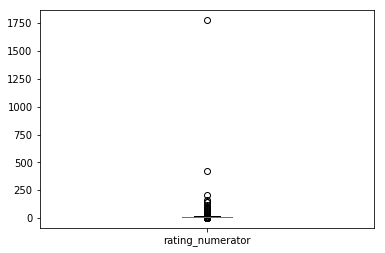

In [117]:
#create boxplot to see outliers

df_weratedogs['rating_numerator'].plot(kind='box')

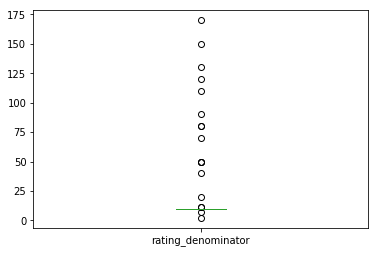

In [118]:
df_weratedogs['rating_denominator'].plot(kind='box')

In [119]:
#identify outliers for rating_numerator

Q1_num =  df_weratedogs['rating_numerator'].quantile(0.25)
Q3_num = df_weratedogs['rating_numerator'].quantile(0.75)
IQR_num = Q3_num - Q1_num

df_weratedogs[(df_weratedogs['rating_numerator'] < Q1_num-1.5*IQR_num ) | (df_weratedogs['rating_numerator'] > Q3_num+1.5*IQR_num)]['rating_numerator']

39         5
176        6
232        0
319       84
381       24
499       75
526        5
548       27
549        3
643        4
657      165
664        4
698        5
720     1776
733        6
742        4
750        0
803        6
842      204
847        6
885        4
909        3
919       50
933        4
940       99
952        6
959        3
964       80
982       45
1005       4
        ... 
1793       6
1799       6
1817       5
1819       3
1822       4
1837       3
1841       5
1856       4
1871       2
1872       6
1873       3
1876       5
1880       2
1893       1
1908       6
1920       4
1936       3
1941       2
1943       5
1947       4
1953       6
1957       2
1961       6
1965       3
1966       1
1969       1
1973       6
1980       2
1982       5
1983       6
Name: rating_numerator, Length: 135, dtype: int64

In [120]:
#identify outliers for rating_denominator

Q1_den =  df_weratedogs['rating_denominator'].quantile(0.25)
Q3_den = df_weratedogs['rating_denominator'].quantile(0.75)
IQR_den = Q3_den - Q1_den

df_weratedogs[(df_weratedogs['rating_denominator'] < Q1_den-1.5*IQR_den ) | (df_weratedogs['rating_denominator'] > Q3_den+1.5*IQR_den)]['rating_denominator']

319      70
381       7
657     150
794      11
842     170
885      20
919      50
940      90
964      80
982      50
1048     50
1124     40
1296    130
1297    110
1322     11
1428    120
1487     80
1966      2
Name: rating_denominator, dtype: int64

In [121]:
# In the overview for rating_numerator above outliers exist in the 0-6 range. These are not outliers. 
# Only the outliers in the > Q3+1.5*IQR category should be removed!

df_weratedogs.drop(df_weratedogs[df_weratedogs.rating_numerator > Q3_num+1.5*IQR_num].index, inplace = True)

In [122]:
# Remove outliers from the rating_denominator column

df_weratedogs.drop(df_weratedogs[df_weratedogs.rating_denominator > Q3_den+1.5*IQR_den].index, inplace = True)
df_weratedogs.drop(df_weratedogs[df_weratedogs.rating_denominator < Q1_den-1.5*IQR_den].index, inplace = True)

##### Test 

In [123]:
# max rating_numerator is 15 and max rating_denominator is 10

df_weratedogs.describe()

,rating_numerator,rating_denominator,img_num,p1_conf,p2_conf,p3_conf,retweet_count,favorite_count
count,1964.000000,1964.0,1964.000000,1964.000000,1.964000e+03,1.964000e+03,1964.000000,1964.000000
mean,10.542770,10.0,1.203666,0.593261,1.349405e-01,6.032184e-02,2349.628819,8015.508147
std,2.185886,0.0,0.562241,0.272049,1.007694e-01,5.083697e-02,4215.640551,11823.549462
min,0.000000,10.0,1.000000,0.044333,1.011300e-08,1.740170e-10,11.000000,69.000000
25%,10.000000,10.0,1.000000,0.360361,5.419487e-02,1.616933e-02,525.750000,1699.250000
50%,11.000000,10.0,1.000000,0.587357,1.186345e-01,4.952715e-02,1129.500000,3606.500000
75%,12.000000,10.0,1.000000,0.843827,1.956673e-01,9.198323e-02,2686.000000,9958.250000
max,14.000000,10.0,4.000000,1.000000,4.880140e-01,2.710420e-01,74404.000000,150774.000000


####  `twitter archive`: A dog cannot be a doggo and a puppo at the same time.

##### Define
In the 'Tidiness' section the doggo, floofer, pupper and puppo columns where already combined. 

####  `twitter archive`: Doggo, pupper, floofer and puppo null-values are filles as None.

##### Define
In the 'Tidiness' section the doggo, floofer, pupper and puppo columns where already combined. During this exercise, the None values were already changed into null-values.

####  `twitter archive`: in the expanded-urls column some urls are mentioned twice or more in the same row

##### Define
Make sure the expanded-urls column only shows one url using split

##### Code 

In [124]:
#remove all unnecessary additional urls using lstrip

df_weratedogs['expanded_urls'] = df_weratedogs['expanded_urls'].str.split(",", n = 1, expand = True)

##### Test 

In [125]:
# broaden the column width to see the full expanded_url column
# index 4 had more than 1 url and now only has 1

pd.options.display.max_colwidth = 100
df_weratedogs['expanded_urls']

0       https://twitter.com/dog_rates/status/892420643555336193/photo/1
1       https://twitter.com/dog_rates/status/892177421306343426/photo/1
2       https://twitter.com/dog_rates/status/891815181378084864/photo/1
3       https://twitter.com/dog_rates/status/891689557279858688/photo/1
4       https://twitter.com/dog_rates/status/891327558926688256/photo/1
5       https://twitter.com/dog_rates/status/891087950875897856/photo/1
6                           https://gofundme.com/ydvmve-surgery-for-jax
7       https://twitter.com/dog_rates/status/890729181411237888/photo/1
8       https://twitter.com/dog_rates/status/890609185150312448/photo/1
9       https://twitter.com/dog_rates/status/890240255349198849/photo/1
10      https://twitter.com/dog_rates/status/890006608113172480/photo/1
11      https://twitter.com/dog_rates/status/889880896479866881/photo/1
12      https://twitter.com/dog_rates/status/889665388333682689/photo/1
13      https://twitter.com/dog_rates/status/889638837579907072/

####  `twitter archive`: in_reply_to_status and in_reply_to_user_id indicate this row is a retweet

##### Define
In the 'Missing Data' section these two columns were already removed.

####  `twitter archive`: the name column contains multiple words that are not dog names: 'a', 'actually', 'all', 'an', 'by', 'getting', 'his', 'incredibly', 'infuriating', 'just', 'life', 'light', 'mad', 'my', 'not', 'officially', 'old', 'one', 'quite', 'space', 'such', 'the', 'this', 'unacceptable', 'very' and 'None'.

##### Define
All the words in the name column that are not dog names are going to be changed into a null-value.

##### Code 

In [126]:
# create list of dog names

name_list = sorted(df_weratedogs['name'].unique().tolist())
name_list

['Abby',
 'Ace',
 'Acro',
 'Adele',
 'Aiden',
 'Aja',
 'Akumi',
 'Al',
 'Albert',
 'Albus',
 'Aldrick',
 'Alejandro',
 'Alexander',
 'Alexanderson',
 'Alf',
 'Alfie',
 'Alfy',
 'Alice',
 'Amber',
 'Ambrose',
 'Amy',
 'Amélie',
 'Anakin',
 'Andru',
 'Andy',
 'Angel',
 'Anna',
 'Anthony',
 'Antony',
 'Apollo',
 'Aqua',
 'Archie',
 'Arlen',
 'Arlo',
 'Arnie',
 'Arnold',
 'Arya',
 'Ash',
 'Asher',
 'Ashleigh',
 'Aspen',
 'Atlas',
 'Atticus',
 'Aubie',
 'Augie',
 'Autumn',
 'Ava',
 'Axel',
 'Bailey',
 'Baloo',
 'Banditt',
 'Banjo',
 'Barclay',
 'Barney',
 'Baron',
 'Batdog',
 'Bauer',
 'Baxter',
 'Bayley',
 'BeBe',
 'Bear',
 'Beau',
 'Beckham',
 'Beebop',
 'Beemo',
 'Bell',
 'Bella',
 'Belle',
 'Ben',
 'Benedict',
 'Benji',
 'Benny',
 'Bentley',
 'Berb',
 'Berkeley',
 'Bernie',
 'Bert',
 'Bertson',
 'Betty',
 'Beya',
 'Biden',
 'Bilbo',
 'Billl',
 'Billy',
 'Binky',
 'Birf',
 'Bisquick',
 'Blakely',
 'Blanket',
 'Blipson',
 'Blitz',
 'Bloo',
 'Bloop',
 'Blu',
 'Blue',
 'Bo',
 'Bob',
 'Bobb'

In [127]:
# eliminate capital letter starting words from string 

res = " ".join([ele for ele in name_list if not ele[0].isupper()]) 
res

'a actually all an by getting his incredibly infuriating just light my not officially one quite space such the unacceptable very'

In [128]:
# create list

word_list = re.sub("[^\w]", " ",  res).split()
word_list

['a',
 'actually',
 'all',
 'an',
 'by',
 'getting',
 'his',
 'incredibly',
 'infuriating',
 'just',
 'light',
 'my',
 'not',
 'officially',
 'one',
 'quite',
 'space',
 'such',
 'the',
 'unacceptable',
 'very']

In [129]:
# if the dog name is in the word_list then it becomes a null-value

df_weratedogs[df_weratedogs.isin(word_list)==True] = np.nan

In [130]:
# if the dog name is None then it become a null-value

df_weratedogs.loc[df_weratedogs['name'] == 'None','name'] = np.nan

##### Test 

In [131]:
# tweet_id 891087950875897856 (index = 4) used to have None and now NaN
# tweet_id 887517139158093824 (index = 21) used to have such as name and now NaN

df_weratedogs

,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,...,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog,retweet_count,favorite_count
0,892420643555336193,2017-08-01 16:23:56,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Phineas. He's a mystical boy. Only ever appears in the hole of a donut. 13/10 https://t....,https://twitter.com/dog_rates/status/892420643555336193/photo/1,13,10,Phineas,,,...,0.097049,False,bagel,0.085851,False,banana,0.076110,False,7371,35060
1,892177421306343426,2017-08-01 00:17:27,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","This is Tilly. She's just checking pup on you. Hopes you're doing ok. If not, she's available fo...",https://twitter.com/dog_rates/status/892177421306343426/photo/1,13,10,Tilly,,,...,0.323581,True,Pekinese,0.090647,True,papillon,0.068957,True,5493,30358
2,891815181378084864,2017-07-31 00:18:03,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Archie. He is a rare Norwegian Pouncing Corgo. Lives in the tall grass. You never know w...,https://twitter.com/dog_rates/status/891815181378084864/photo/1,12,10,Archie,,,...,0.716012,True,malamute,0.078253,True,kelpie,0.031379,True,3631,22818
3,891689557279858688,2017-07-30 15:58:51,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Darla. She commenced a snooze mid meal. 13/10 happens to the best of us https://t.co/tD3...,https://twitter.com/dog_rates/status/891689557279858688/photo/1,13,10,Darla,,,...,0.170278,False,Labrador_retriever,0.168086,True,spatula,0.040836,False,7549,38335
4,891327558926688256,2017-07-29 16:00:24,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","This is Franklin. He would like you to stop calling him ""cute."" He is a very fierce shark and sh...",https://twitter.com/dog_rates/status/891327558926688256/photo/1,12,10,Franklin,,,...,0.555712,True,English_springer,0.225770,True,German_short-haired_pointer,0.175219,True,8137,36610
5,891087950875897856,2017-07-29 00:08:17,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Here we have a majestic great white breaching off South Africa's coast. Absolutely h*ckin breath...,https://twitter.com/dog_rates/status/891087950875897856/photo/1,13,10,NaN,,,...,0.425595,True,Irish_terrier,0.116317,True,Indian_elephant,0.076902,False,2726,18460
6,890971913173991426,2017-07-28 16:27:12,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Meet Jax. He enjoys ice cream so much he gets nervous around it. 13/10 help Jax enjoy more thing...,https://gofundme.com/ydvmve-surgery-for-jax,13,10,Jax,,,...,0.341703,True,Border_collie,0.199287,True,ice_lolly,0.193548,False,1764,10739
7,890729181411237888,2017-07-28 00:22:40,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",When you watch your owner call another dog a good boy but then they turn back to you and say you...,https://twitter.com/dog_rates/status/890729181411237888/photo/1,13,10,NaN,,,...,0.566142,True,Eskimo_dog,0.178406,True,Pembroke,0.076507,True,16505,59036
8,890609185150312448,2017-07-27 16:25:51,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Zoey. She doesn't want to be one of the scary sharks. Just wants to be a snuggly pettabl...,https://twitter.com/dog_rates/status/890609185150312448/photo/1,13,10,Zoey,,,...,0.487574,True,Irish_setter,0.193054,True,Chesapeake_Bay_retriever,0.118184,True,3778,25408
9,890240255349198849,2017-07-26 15:59:51,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Cassie. She is a college pup. Studying international doggo communication and stick theor...,https://twitter.com/dog_rates/status/890240255349198849/photo/1,14,10,Cassie

# Storing
Store the clean DataFrame in a CSV file with the main one named twitter_archive_master.csv

In [132]:
df_weratedogs.to_csv('twitter_archive_master.csv', index=False)

# Analyzing and Visualizing Data

In this section the data will be analyzed and visualized. The following insights and/or visuals will be discussed:

- Which names are most common on the WeRateDogs Twitter?
- Are dogs with a high numerator rating more retweeted and/or do they a have a higher favourite count?
- Which breeds are most common on the WeRateDogs Twitter?
- Which breed has the highest average numerator rating?

### Which names are most common on the WeRateDogs Twitter?
The names Oliver, Charlie and Cooper all appear 10 times in the dataframe. Also Tucker, Penny and Lucy are popular names on the WeRateDogs Twitter page. 

Text(0.5,1,'Top 15 Most Common Dog Names')

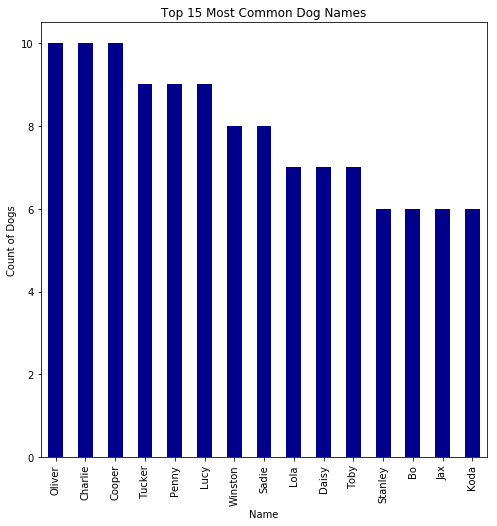

In [133]:
#Create a barchart with value_counts

df_weratedogs['name'].value_counts().head(15).plot(kind='bar', color = 'DarkBlue', figsize=(8,8))
plt.xlabel('Name')
plt.ylabel('Count of Dogs')
plt.title("Top 15 Most Common Dog Names")

### Are dogs with a high numerator rating more retweeted and/or do they a have a higher favourite count?
It cannot be concluded that the higher the numerator rating score the higher the average retweet and favorite count is. However, if we exclude the till 7 score (since earlier it was stated that the scores 0 - 6 could be excluded because they are outliers) than it can be concluded that the a high numerator rating is more retweeted and has a higher favourite count.

So we can conclude that the the statement 'Dogs with a high numerator rating are more retweeted and have a higher favourite count' is partially true.

Furthermore, we can conlude that that the trendline for the retweet count is shaped similar as the favourite count, only the favourite count numbers are a bit lower.

Text(0.5,1,'Average Retweet or Favorite Count per Numerator Rating Score')

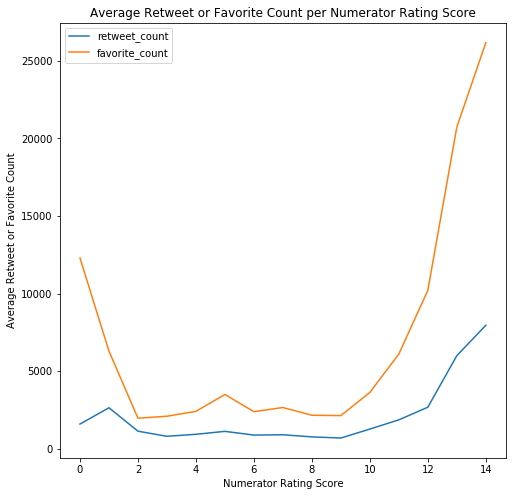

In [134]:
#Create a linechart with groupby

df_weratedogs.groupby('rating_numerator').mean()[['retweet_count','favorite_count']].plot(kind='line', figsize=(8,8))
plt.xlabel('Numerator Rating Score')
plt.ylabel('Average Retweet or Favorite Count')
plt.title("Average Retweet or Favorite Count per Numerator Rating Score")

### Which breeds are most common on the WeRateDogs Twitter?
The Golden Retriever is definately the breed that is most common on the WeRateDogs Twitter account. The Labrador Retriever and Pembroke are the number 2 and 3. 

In [135]:
#Create a breed list based on the highest confidence and a TRUE score

breed = []

for ind in df_weratedogs.index:
    if df_weratedogs['p1_dog'][ind] == True:
        breed.append(df_weratedogs['p1'][ind])
    elif df_weratedogs['p2_dog'][ind] == True:
        breed.append(df_weratedogs['p2'][ind])
    elif df_weratedogs['p3_dog'][ind] == True:
        breed.append(df_weratedogs['p3'][ind])
    else:
        breed.append(np.nan)

In [136]:
# add the breed list to the dataframe

df_weratedogs['breed'] = breed

Text(0.5,1,'Top 15 Most Common Dog Breeds')

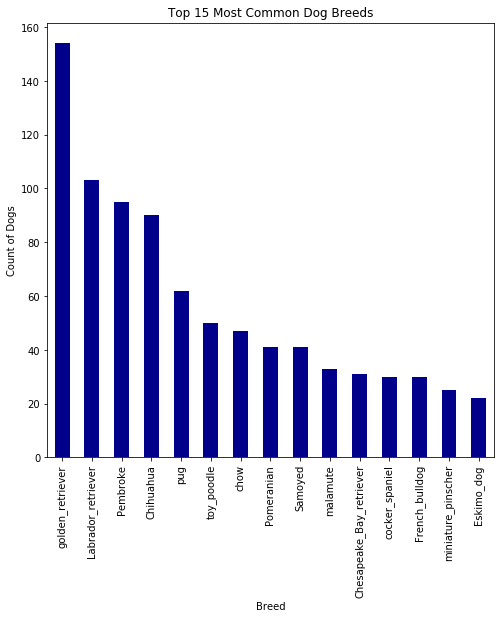

In [137]:
#Create a barchart with value_counts

df_weratedogs['breed'].value_counts().head(15).plot(kind='bar', color = 'DarkBlue', figsize=(8,8))
plt.xlabel('Breed')
plt.ylabel('Count of Dogs')
plt.title("Top 15 Most Common Dog Breeds")

### Which breed has the highest average numerator rating?
The Bouvier des Flandres has the highest average numerator rating, followed by the Saluki and the Briard. The Golden Retriever (which was the most tweeted dog breed) is also in the Top 15, namely on place 11.

Text(0.5,1,'Top 15 Higest Average Numerator Scores per Breed')

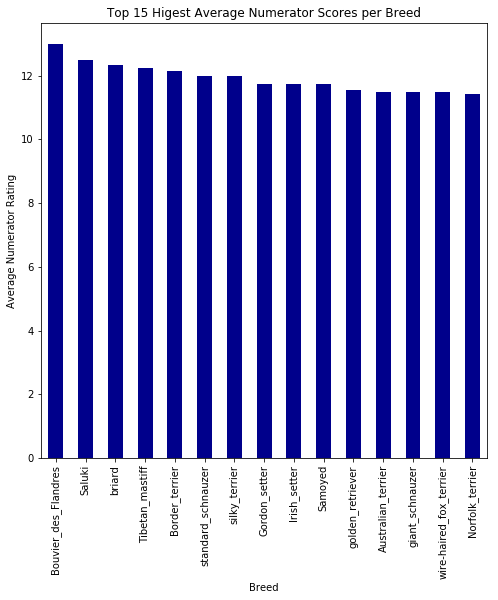

In [138]:
df_weratedogs.groupby('breed').mean()['rating_numerator'].sort_values(ascending=False).head(15).plot(kind='bar', color = 'DarkBlue', figsize=(8,8))
plt.xlabel('Breed')
plt.ylabel('Average Numerator Rating')
plt.title("Top 15 Higest Average Numerator Scores per Breed")

### Conclusion
We can conclude that firstly Oliver, Charlie and Cooper are the most common names in the dataframe. Secondly, if the numerator rating is above 7, the higher the numerator, the more the tweet is retweeted and the higher the favourite count. Furthermore, the Golden Retriever is the most common dog breed. And finally, the Bouvier des Flandres has the highest average numerator rating.